In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import folium
import os
import folium.plugins as plugins
import geopandas as gpd

In [2]:
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()
def json_dir(data, data_dir = 'altairdata'):
    os.makedirs(data_dir, exist_ok = True)
    return alt.pipe(data, alt.to_json(filename = data_dir + '/{prefix}-{hash}.{extension}'))
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir', data_dir = 'mydata')

DataTransformerRegistry.enable('json_dir')

In [3]:
df = pd.read_csv('Complaints.csv')
arrestReports = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_.csv')
precinctMap = gpd.read_file('PolicePrecincts.geojson')
df['complainant_ethnicity'] = df['complainant_ethnicity'].fillna('Unknown')
df = df.replace({'precinct': {1000:22}})

C:\Users\owenw\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
arrestReports = arrestReports[['VIC_RACE','VIC_AGE_GROUP','Latitude','Longitude']]
arrestReports = arrestReports.drop(arrestReports[arrestReports['VIC_RACE'] == 'UNKNOWN'].index).reset_index()
geoArrestReports = gpd.GeoDataFrame(arrestReports, geometry = gpd.points_from_xy(arrestReports.Longitude,arrestReports.Latitude))

In [5]:
geoArrestReports.crs = precinctMap.crs
geoArrestReports = gpd.sjoin(geoArrestReports,precinctMap,how = 'inner')

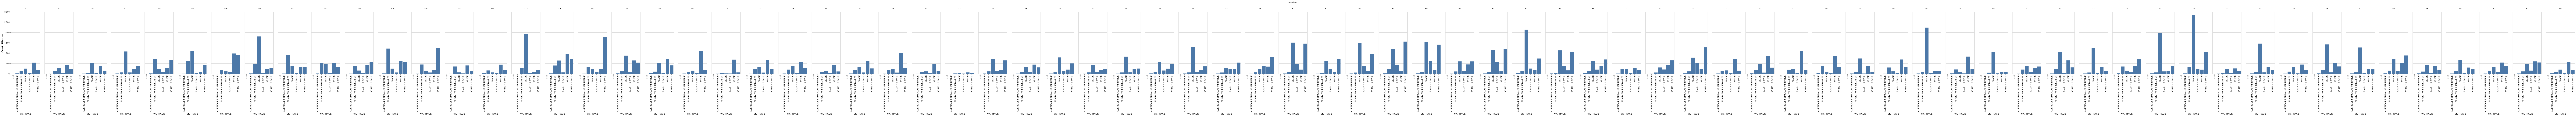

In [6]:
alt.Chart(geoArrestReports).mark_bar().encode(
    x = 'VIC_RACE:N',
    y = 'count(VIC_RACE):Q',
    column = 'precinct',
)

In [7]:
precincts = pd.DataFrame(columns = ['precinct'])
precincts['precinct'] = np.sort(df['precinct'].unique())
precincts = precincts.join(df.groupby(['precinct']).size().to_frame(name = 'Number of Complaints'),on = 'precinct')
keys = precincts['precinct'].unique()
values = [190,141,164,142,178,162,190,307,141,294,207,
         149,120,176,156,210,134,167,142,205,191,201,
         284,186,221,293,358,174,306,280,252,193,133,
         282,202,167,154,155,138,333,138,161,303,216,
         179,275,399,139,235,198,247,197,209,221,155,
         185,142,145,206,209,254,182,310,225,197,148,
         292,211,153,144,236,261,234,311,196,195,144]
substantiatedCols = ['Substantiated (Charges)','Substantiated (Command Discipline A)',
       'Substantiated (Formalized Training)',
       'Substantiated (Command Lvl Instructions)',
       'Substantiated (Instructions)',
       'Substantiated (Command Discipline)',
       'Substantiated (Command Discipline B)',
       'Substantiated (No Recommendations)',
       'Substantiated (MOS Unidentified)']

In [8]:
UniformedDict = dict(zip(keys,values))
def amtUniformed(precinct):
    return UniformedDict[precinct]

In [9]:
precincts['Uniformed Officers'] = precincts['precinct']
precincts['Uniformed Officers'] = precincts['Uniformed Officers'].apply(amtUniformed)
precincts['Complaints per Officer'] = precincts['Number of Complaints'] / precincts['Uniformed Officers']

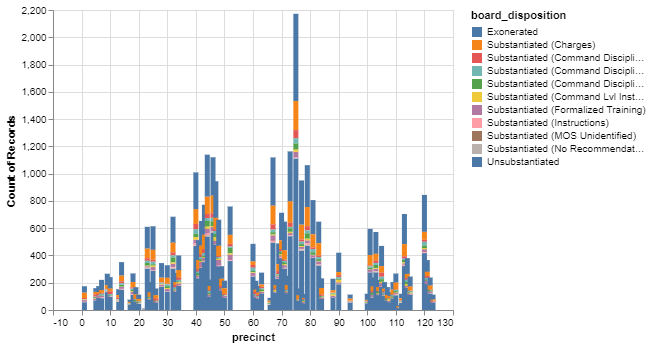

In [20]:
alt.Chart(df.where(df['precinct'] < 300)).mark_bar().encode(
    x = 'precinct',
    y = 'count(precinct):Q',
    color = 'board_disposition'
)

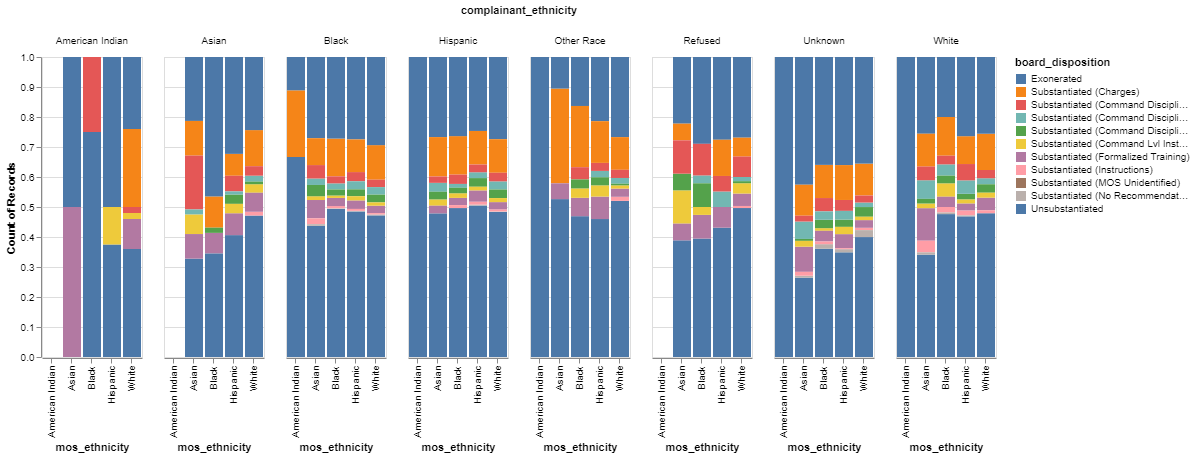

In [19]:
alt.Chart(df.where(df['precinct'] < 300)).mark_bar().encode(
    x = 'mos_ethnicity',
    y = alt.Y('count(mos_ethnicity)',stack = 'normalize'),
    column = 'complainant_ethnicity:N',
    color = 'board_disposition'
)

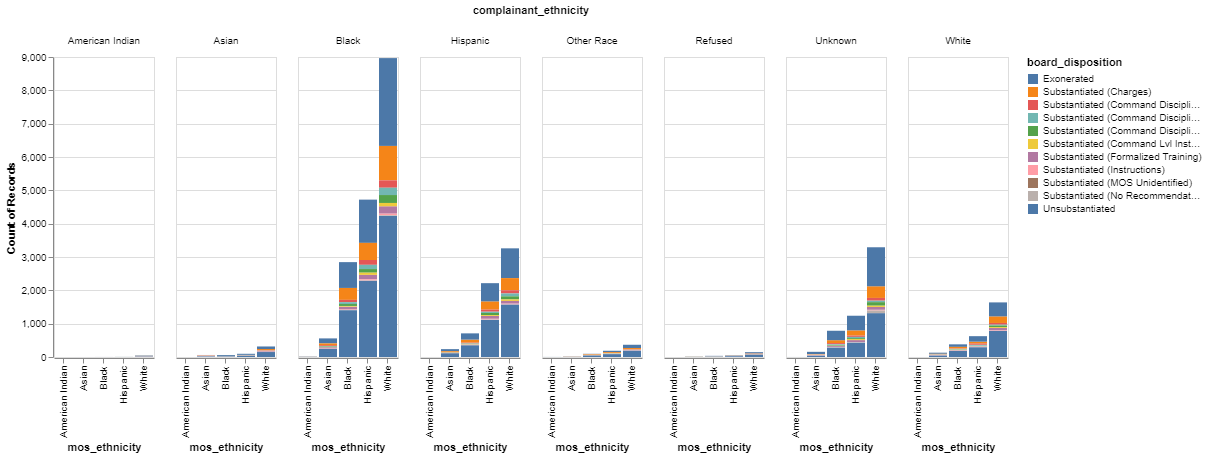

In [12]:
alt.Chart(df.where(df['precinct'] < 300)).mark_bar().encode(
    x = 'mos_ethnicity',
    y = alt.Y('count(mos_ethnicity)'),
    column = 'complainant_ethnicity:N',
    color = 'board_disposition'
)

### Pivot Tables

Get count of complainant ethnicities

In [13]:
complainantdf = pd.pivot_table(df,values = ['first_name'],index = ['precinct'],columns = ['complainant_ethnicity'],aggfunc = 'count')['first_name']

Get count of mo ethnicities

In [14]:
modf = pd.pivot_table(df,values = ['first_name'],index = ['precinct'],columns = ['mos_ethnicity'],aggfunc = 'count')['first_name']

Get outcomes

In [15]:
outdf = pd.pivot_table(df,values = ['first_name'],index = ['precinct'],columns = ['board_disposition'],aggfunc = 'count')['first_name']
outdf = outdf.assign(Substantiated = outdf[substantiatedCols].sum(1)).drop(substantiatedCols,1)

Get year ranges

In [16]:
yeardf = pd.pivot_table(df,values = ['year_received'],index = ['precinct'],aggfunc = ['min','max'])

In [18]:
precincts = precincts.join(outdf, on = 'precinct', how = 'inner')
precincts = precincts.join(modf, on = 'precinct',how = 'inner')
precincts = precincts.join(complainantdf, on = 'precinct', how = 'inner',lsuffix = ' Mo', rsuffix = ' Complainant')
precincts = precincts.join(yeardf, on = 'precinct', how = 'inner')

C:\Users\owenw\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [10]:
# Initialize the map with a restriction on zoom
choroplethPopup = folium.Map([34.055862, -118.326904], max_zoom = 12)

# Make a container for all the geo blocks
zipcodeLayer = folium.FeatureGroup(name = 'Zip Codes')
# We'll want the overlays to be transparent so they don't cover up the choropleth
transparent = {'fillColor': '#00000000', 'color': '#00000000'}

# Create the choropleth based on the total counts within each zip
folium.Choropleth(
    geo_data = cityzipCodes,
    name = 'Choropleth',
    data = counts,
    columns = ['Zip', 'Total'],
    key_on = 'feature.properties.ZIPCODE',
    fill_color = 'BuPu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Total Crimes').add_to(choroplethPopup)

# For every zip code define its geoJson as a separate area attach a popup then put it in the container
for i in zipCodeArray:
    datarow = counts.where(counts['Zip'] == i).dropna().iloc[0]
    gs = folium.GeoJson(zipCodes.loc[zipCodes['ZIPCODE'] == i], style_function = lambda x: transparent)
    zipCodelabel = i
    crimeslabel = datarow['Crime Count']
    arrestslabel = datarow['Arrest Count']
    totallabel = datarow['Total']
    populationlabel = populations.where(populations['Zip'] == i).dropna().iloc[0]['Total Population']
    homeValuelabel = int(homeValue.where(homeValue['Zip'] == i).dropna().iloc[0]['Zhvi'])
    streetlightslabel = datarow['Streetlight Count']
    popuphtml = """
            <html>
                <body>
                    <h1>%s</h1>
                    <p>Number of Crimes Commited: %s</p>
                    <p>Number of Arrests Made: %s</p>
                    <p>Total: %s</p>
                    <p>Median Home Price: %s</p>
                    <p>Population: %s</p>
                    <p>Number of Streetlights: %s</p>
                </body>
            </html>"""%(zipCodelabel, str(crimeslabel), str(arrestslabel), str(totallabel), 
                        str(homeValuelabel), str(populationlabel), str(streetlightslabel))
    folium.Popup(popuphtml,max_width = 250, sticky = True).add_to(gs)
    gs.add_to(zipcodeLayer)
    
# Add the geoJson container then add the layer controller
choroplethPopup.add_child(zipcodeLayer)
folium.LayerControl().add_to(choroplethPopup)

NameError: name 'cityzipCodes' is not defined